In [12]:
import argparse
import logging
from pathlib import Path
from typing import Literal, Optional

import numpy as np
import pandas as pd
from utils import (
    calculate_weights,
    get_available_trackers,
    load_trackers,
    get_rebalance_dates,
    cap_long_only_weights,
)
from backtest import backtest2
from entities import FX_TRACKER_DICT, EM_CDS_TRACKER_DICT

from bwlogger import StyleAdapter, basic_setup
from bwutils import open_file
from portfolio.construction import calculate_weights as calculate_weights_fh

In [25]:
FOLDER = Path("C:/Users/pcampos/OneDrive - Insper - Instituto de Ensino e Pesquisa/Dissertação Mestrado/Analysis/backtests")
list_series = []
for file_path in FOLDER.glob("*.xlsx"):
    s_backtest = pd.read_excel(file_path, index_col=0)["backtest"]
    s_backtest.name = file_path.stem
    list_series.append(s_backtest)
df_backtest = pd.concat(list_series, axis=1)


<Axes: xlabel='date'>

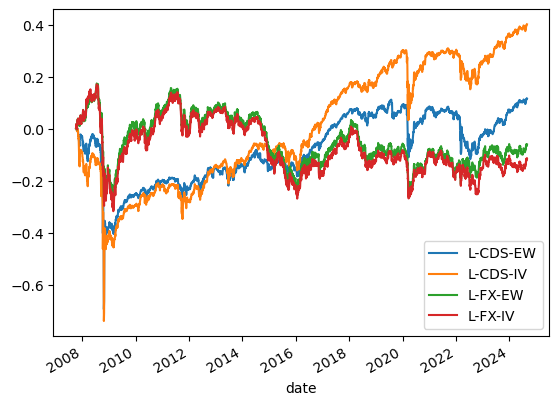

In [26]:
np.log(df_backtest.dropna(how="any")).diff(1).cumsum().plot()